Interesting paper: http://cobweb.cs.uga.edu/~liao/PE_Final_Report.pdf

PE header: https://drive.google.com/file/d/0B3_wGJkuWLytbnIxY1J5WUs4MEk/view
PE header (MS): https://msdn.microsoft.com/en-us/library/ms809762.aspx

https://github.com/erocarrera/pefile

Adapted from:

* https://www.randhome.io/blog/2016/07/16/machine-learning-for-malware-detection/
* http://nbviewer.jupyter.org/github/ClickSecurity/data_hacking/blob/master/pefile_classification/pefile_classification.ipynb

https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/
http://nbviewer.jupyter.org/github/ClickSecurity/data_hacking/blob/master/pefile_classification/pefile_classification.ipynb

** SOURCE FILES **

Original files (pefile_data.csv):

* Good (various .EXEs from Win OSs)  6,502
* Bad: 7,664

New files (pefile_data_2.csv):

* DLLs  7,001
* New bad files 6,387

In [11]:
%matplotlib inline

import sklearn.feature_extraction
import numpy as np
import pandas as pd
import sklearn
import sklearn.ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import pickle
from sklearn.externals import joblib
import os, warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = 8,5

In [12]:
data = pd.read_csv('pefile_data_combined_PLAY.csv', sep='|') # Read the CSV file into a Pandas dataframe

C:\Users\Paul Lipman\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
list(data)

['Name',
 'md5',
 'Machine',
 'SizeOfOptionalHeader',
 'Characteristics',
 'MajorLinkerVersion',
 'MinorLinkerVersion',
 'SizeOfCode',
 'SizeOfInitializedData',
 'SizeOfUninitializedData',
 'AddressOfEntryPoint',
 'BaseOfCode',
 'BaseOfData',
 'ImageBase',
 'SectionAlignment',
 'FileAlignment',
 'MajorOperatingSystemVersion',
 'MinorOperatingSystemVersion',
 'MajorImageVersion',
 'MinorImageVersion',
 'MajorSubsystemVersion',
 'MinorSubsystemVersion',
 'SizeOfImage',
 'SizeOfHeaders',
 'CheckSum',
 'Subsystem',
 'DllCharacteristics',
 'SizeOfStackReserve',
 'SizeOfStackCommit',
 'SizeOfHeapReserve',
 'SizeOfHeapCommit',
 'LoaderFlags',
 'NumberOfRvaAndSizes',
 'SectionsNb',
 'SectionsMeanEntropy',
 'SectionsMinEntropy',
 'SectionsMaxEntropy',
 'SectionsMeanRawsize',
 'SectionsMinRawsize',
 'SectionMaxRawsize',
 'SectionsMeanVirtualsize',
 'SectionsMinVirtualsize',
 'SectionMaxVirtualsize',
 'ImportsNbDLL',
 'ImportsNb',
 'ImportsNbOrdinal',
 'ExportNb',
 'ResourcesNb',
 'ResourcesMeanE

In [14]:
data.shape[0]

38591

In [15]:
data.head()

,Name,md5,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,...,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,Status
0,0008-64bit_Win7_Win8_Win81_Win10_R281.exe,571e83eda0c694f1c6634073d88ed8b6,332,224,271,6,0,69632,98304,0,...,24,0.0,2.058606,4.378816,0.0,62,52560,0,7,Clean
1,2c6f74be8013d301f80d0000b821d42f.ShellExperien...,11c97664d7aeaebff1387f8804acd0ba,34404,240,34,14,10,1159168,843776,0,...,1,0.0,3.452395,3.452395,0.0,976,976,244,7,Clean
2,2to3.exe,d2778164ef643ba8f44cc202ec7ef157,34404,240,35,9,0,54784,27136,0,...,0,0.0,0.000000,0.000000,0.0,0,0,0,0,Clean
3,32BitMAPIBroker.exe,962f4fb1f6e9d787211b0132fad6e0d5,332,224,258,12,0,72704,25088,0,...,2,0.0,3.459352,4.911615,0.0,381,900,72,7,Clean
4,4af598f00a2dd301100d0000cc1b341b.ShellExperien...,11c97664d7aeaebff1387f8804acd0ba,34404,240,34,14,10,1159168,843776,0,...,1,0.0,3.452395,3.452395,0.0,976,976,244,7,Clean


In [16]:
clean = data.loc[data['Status'] == 'Clean'] 
clean.shape[0]

18564

In [17]:
malicious = data.loc[data['Status'] == 'Malicious'] 
malicious.shape[0]

20027

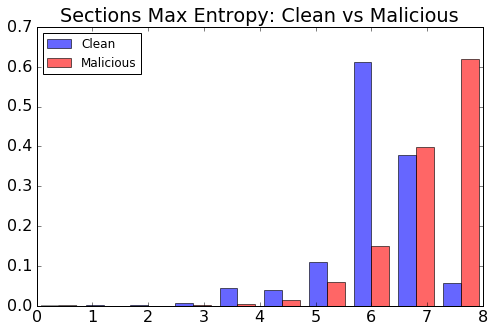

In [18]:
# Example of an attribute with clear differences b/w clean & malicious EXEs

plt.title('Sections Max Entropy: Clean vs Malicious')
plt.hist([clean['SectionsMaxEntropy'],malicious['SectionsMaxEntropy']],
         range = [0,8], normed=True, alpha = .6, color=["blue","red"], label=["Clean","Malicious"]);
plt.legend(loc='upper left',fontsize = 12)

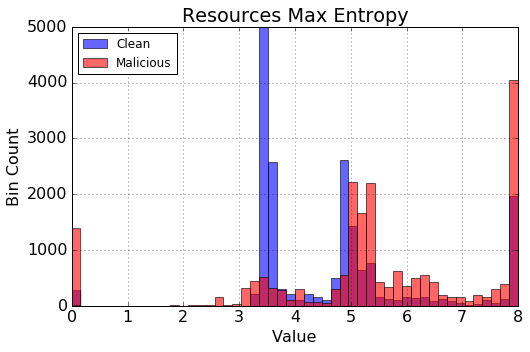

In [19]:
clean["ResourcesMaxEntropy"].hist(bins=50, figsize=(8,5), edgecolor='black',alpha=0.6,label='Clean')
malicious["ResourcesMaxEntropy"].hist(bins=50, figsize=(8,5), color='red', edgecolor='black', alpha=0.6,label='Malicious')
plt.title("Resources Max Entropy")
plt.ylabel("Bin Count")
plt.xlabel("Value")
plt.legend(fontsize=12,loc=2)


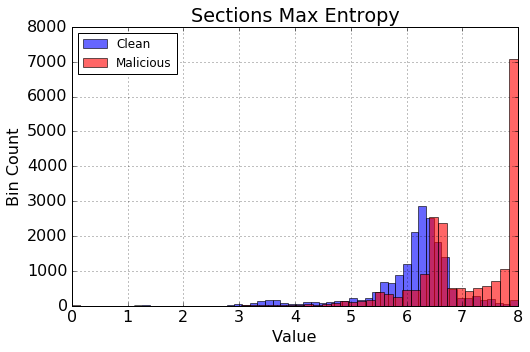

In [30]:
clean["SectionsMaxEntropy"].hist(bins=50, figsize=(8,5), edgecolor='black',alpha=0.6,label='Clean')
malicious["SectionsMaxEntropy"].hist(bins=50, figsize=(8,5), color='red', edgecolor='black', alpha=0.6,label='Malicious')
plt.title("Sections Max Entropy")
plt.ylabel("Bin Count")
plt.xlabel("Value")
plt.legend(fontsize=12,loc=2)

(0, 1000)

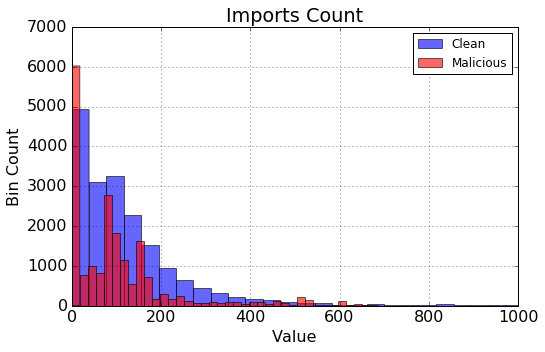

In [33]:
clean["ImportsNb"].hist(bins=200, figsize=(8,5), color='blue', edgecolor='black',alpha=0.6,label='Clean')
malicious["ImportsNb"].hist(bins=200, figsize=(8,5), color='red', edgecolor='black', alpha=0.6,label='Malicious')
plt.title("Imports Count")
plt.ylabel("Bin Count")
plt.xlabel("Value")
plt.legend(fontsize=12,loc=1)
plt.xlim(0,1000)

**Another Approach**

* Using: https://www.randhome.io/blog/2016/07/16/machine-learning-for-malware-detection/
* http://scikit-learn.org/stable/modules/feature_selection.html#tree-based-feature-selection

In [22]:
X = data.drop(['Name','md5','Status'],axis = 1).values # remove alpha columns
y = data['Status'].values

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [24]:
rnd_clf = sklearn.ensemble.RandomForestClassifier(n_estimators=50, n_jobs = -1)
rnd_clf.fit(X_train,y_train)
y_pred_rf = rnd_clf.predict(X_test)

In [25]:
rnd_mt = confusion_matrix(y_test, y_pred_rf)

print("Score: %.2f %%" % (100 * rnd_clf.score(X_test, y_test)))
print("False positive rate : %.2f %%" % ((rnd_mt[0][1] / float(sum(rnd_mt[0])))*100))
print('False negative rate : %.2f %%' % ( (rnd_mt[1][0] / float(sum(rnd_mt[1]))*100)))

Score: 98.89 %
False positive rate : 1.38 %
False negative rate : 0.86 %


In [26]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=5),n_estimators=50,
    algorithm="SAMME.R",learning_rate=0.5)
ada_clf.fit(X_train,y_train)
y_pred_ada = ada_clf.predict(X_test)

ada_mt = confusion_matrix(y_test, y_pred_ada)

print("Score: %.2f %%" % (100 * ada_clf.score(X_test, y_test)))
print("False positive rate : %.2f %%" % ((ada_mt[0][1] / float(sum(ada_mt[0])))*100))
print('False negative rate : %.2f %%' % ( (ada_mt[1][0] / float(sum(ada_mt[1]))*100)))

Score: 98.66 %
False positive rate : 1.64 %
False negative rate : 1.05 %


In [27]:
# [::-1] reverses the order of the array
# [:nb_features] grabs only the features that were selected by the classifier
# 2+ needed b/c 0th is Name and 1st is md5

model = sklearn.feature_selection.SelectFromModel(ada_clf,prefit=True)
X_new = model.transform(X)
X_new.shape

nb_features = X_new.shape[1]
indices = np.argsort(ada_clf.feature_importances_)[::-1][:nb_features]

features = []

for f in range(nb_features):
    print("%d. feature %s (%f)" %(f+1,data.columns[2+indices[f]],
                                 ada_clf.feature_importances_[indices[f]]))

1. feature CheckSum (0.073594)
2. feature ResourcesMaxEntropy (0.067474)
3. feature SectionsMaxEntropy (0.065237)
4. feature ResourcesMaxSize (0.057179)
5. feature AddressOfEntryPoint (0.053631)
6. feature ImportsNb (0.039703)
7. feature ResourcesMinEntropy (0.035639)
8. feature ImageBase (0.035196)
9. feature SectionMaxVirtualsize (0.033554)
10. feature SectionsMinEntropy (0.033066)
11. feature ResourcesNb (0.032253)
12. feature Characteristics (0.031890)
13. feature ResourcesMinSize (0.031820)
14. feature SizeOfImage (0.027765)
15. feature SizeOfInitializedData (0.027555)
16. feature MajorLinkerVersion (0.026151)
17. feature DllCharacteristics (0.025808)
18. feature SectionMaxRawsize (0.025286)
19. feature SectionsMinVirtualsize (0.024182)
20. feature ImportsNbDLL (0.023280)
21. feature BaseOfData (0.022467)


In [28]:
all_features = X.shape[1]
indices = np.argsort(ada_clf.feature_importances_)[::-1][:all_features]

features = []

for f in range(all_features):
    print("%d. feature %s (%f)" %(f+1,data.columns[2+indices[f]],
                                 ada_clf.feature_importances_[indices[f]]))

for f in sorted(np.argsort(ada_clf.feature_importances_)[::-1][:all_features]):
    features.append(data.columns[2+f])

1. feature CheckSum (0.073594)
2. feature ResourcesMaxEntropy (0.067474)
3. feature SectionsMaxEntropy (0.065237)
4. feature ResourcesMaxSize (0.057179)
5. feature AddressOfEntryPoint (0.053631)
6. feature ImportsNb (0.039703)
7. feature ResourcesMinEntropy (0.035639)
8. feature ImageBase (0.035196)
9. feature SectionMaxVirtualsize (0.033554)
10. feature SectionsMinEntropy (0.033066)
11. feature ResourcesNb (0.032253)
12. feature Characteristics (0.031890)
13. feature ResourcesMinSize (0.031820)
14. feature SizeOfImage (0.027765)
15. feature SizeOfInitializedData (0.027555)
16. feature MajorLinkerVersion (0.026151)
17. feature DllCharacteristics (0.025808)
18. feature SectionMaxRawsize (0.025286)
19. feature SectionsMinVirtualsize (0.024182)
20. feature ImportsNbDLL (0.023280)
21. feature BaseOfData (0.022467)
22. feature SizeOfStackReserve (0.016661)
23. feature VersionInformationSize (0.016432)
24. feature ResourcesMeanEntropy (0.015853)
25. feature ImportsNbOrdinal (0.013735)
26. fe

In [29]:
joblib.dump(ada_clf, 'classifier.pkl')
open('features.pkl', 'wb').write(pickle.dumps(features))

1273